# A Gentle Introduction to Continual Learning in PyTorch

In this brief tutorial we will learn the basics of *Continual Learning* using *PyTorch*. We will use the standard MNIST benchmark so that you can swiftly run this notebook from anywhere!

This notebook is part of the **[Continual AI Colab](https://github.com/ContinualAI/colab)** is a repository meant for tutorials and demo running on Google Colaboratory. [Continual AI](https://www.continualai.org/) is an open research community on the topic of Continual Learning and AI! Join us today [on slack](https://continualai.herokuapp.com/)! :-D

We will start with learning over the standard *MNIST* benchmark, then we will move in the actual continual learning setting  with the *Permuted MNIST* benchmark. Let's have some fun! :-)


---
** Connecting a local runtime**

In case resources are not enough for you (no GPU for example), you can always connect another [local runtime](https://research.google.com/colaboratory/local-runtimes.html) or to a [runtime on a Google Compute Engine instance](https://research.google.com/colaboratory/local-runtimes.html).

This notebook has been designed to run fast enough on simple CPUs so you shouldn't find any trouble here, using a free *hosted account*.

---


**Requisites to run it locally, outside colab (not recommended)**

*   Python 3.x
*   Jupyter
*   PyTorch >= 1.8
*   NumPy
*   Matplotlib
---



## Google Colaboratory

First of all, take a moment to look around and discover Google Colab if you haven't before! You can run the commands below to understand how much resources you're using and are still available. Then consider also that you can also connect your Google Drive for additional space or for easily loading your own files.

You can always reset the entire VM with "*Runtime > Reset all runtime*" in case of difficulty. Make also sure you're using the GPU or TPU in the same  tab ("*Runtime > Change runtime type*").

In [1]:
!free -m
!df -h
!nvidia-smi

               total        used        free      shared  buff/cache   available
Mem:           12978         905        6256          12        5817       11749
Swap:              0           0           0
Filesystem      Size  Used Avail Use% Mounted on
overlay          79G   27G   52G  35% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.1G  849M  57% /usr/sbin/docker-init
/dev/sda1       106G   80G   26G  76% /opt/bin/.nvidia
tmpfs           6.4G   11M  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
Sat Apr 20 11:22:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------

**Questions to explore:**

*   How to connect your Google Drive with Google Colab?
*   How to import a new notebook and save it to your GDrive?
*   How to use files which are contained in your GDrive?

Some tips here: https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d


Ok, if you are on Colab PyTorch is already installed! Let's import it and see if it can find the GPU:

In [2]:
import torch
torch.cuda.is_available()

True

That's great, let us import then a few libraries, which we'll be using during this tutorial!

In [3]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Subset

## MNIST: Digits recognition with PyTorch

All right, let's start then making sure we all know the basics! Let's recognize the ten handwritten digits learning from 60.000, 28x28 grayscale images.
For simplicity let's import a loading script we have already developed inside the **Continual AI Colab** repository:

In [4]:
!git clone https://github.com/ContinualAI/colab.git continualai/colab

fatal: destination path 'continualai/colab' already exists and is not an empty directory.


In [5]:
from continualai.colab.scripts import mnist
mnist.init()

Files already downloaded!


In [6]:
x_train, t_train, x_test, t_test = mnist.load()

print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


In [7]:
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True)
x_test, t_test = (np.moveaxis(testset.data, 3, 1)/255.).astype(np.float32), np.array(testset.targets, dtype=np.uint8)
x_train, t_train = (np.moveaxis(trainset.data, 3, 1)/255.).astype(np.float32), np.array(trainset.targets,  dtype=np.uint8)

print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

Files already downloaded and verified
Files already downloaded and verified
x_train dim and type:  (50000, 3, 32, 32) float32
t_train dim and type:  (50000,) uint8
x_test dim and type:  (10000, 3, 32, 32) float32
t_test dim and type:  (10000,) uint8


In [8]:
def get_classes() -> tuple:
    """Return class labels of CIFAR-10 dataset."""
    return ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")


def get_datasets(tasks: int) -> tuple[list[Subset], list[Subset]]:
    """Split CIFAR-10 dataset into task specific subsets.

    Args:
        tasks (int): Number of tasks to split the dataset into.

    Returns:
        tuple[list[Subset], list[Subset]]: Tuple containing two list with the train and test subsets.
    """
    classes = get_classes()
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
    classes_per_task = torch.linspace(0, len(classes), tasks + 1, dtype=torch.int)
    trainsets = []
    testsets = []
    train_targets = torch.tensor(trainset.targets)
    test_targets = torch.tensor(testset.targets)
    for i in range(len(classes_per_task) - 1):
        train_indices = []
        test_indices = []
        for j in range(classes_per_task[i], classes_per_task[i + 1]):
            train_indices.extend((train_targets == j).nonzero(as_tuple=False).flatten().tolist())
            test_indices.extend((test_targets == j).nonzero(as_tuple=False).flatten().tolist())
        trainsets.append(Subset(trainset, train_indices))
        testsets.append(Subset(testset, test_indices))
    return trainsets, testsets

In [9]:
trainsets, testsets = get_datasets(5)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
x_test, t_test = np.empty((2000, 3, 32, 32), dtype=np.float32), np.empty(2000, dtype=np.uint8)
for i, (X, y) in enumerate(testsets[0]):
    x_test[i, :, :, :] = X
    t_test[i] = y

In [11]:
x_train, t_train = np.empty((10000, 3, 32, 32), dtype=np.float32), np.empty(10000, dtype=np.uint8)
for i, (X, y) in enumerate(trainsets[0]):
    x_train[i, :, :, :] = X
    t_train[i] = y

In [12]:
print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (10000, 3, 32, 32) float32
t_train dim and type:  (10000,) uint8
x_test dim and type:  (2000, 3, 32, 32) float32
t_test dim and type:  (2000,) uint8


Let's take a look at the actual images!

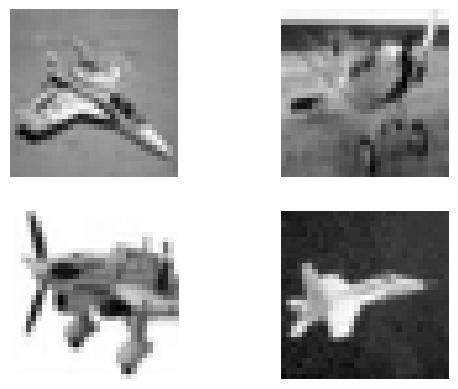

In [13]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train[1, 0], cmap="gray")
axarr[0,1].imshow(x_train[2, 0], cmap="gray")
axarr[1,0].imshow(x_train[3, 0], cmap="gray")
axarr[1,1].imshow(x_train[4, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

Good! Let's now set up a few general setting before using torch...

In [14]:
# switch to False to use CPU
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1);

... and define our first conv-net! We will use 3 layers of convolutions and two fully connected layers:

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 70)
        self.fc2 = nn.Linear(70, 10)
        self.flatten = torch.nn.Flatten()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

Then we can write the *train* and *test* functions. Note that for simplicity here we are not using PyTorch [Data Loaders](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) but this is not recommended for efficiency.

In [16]:
def train(model, device, x_train, t_train, optimizer, epoch):
    model.train()

    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)

      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

Then we are ready to instantiate our model and start the training!

In [17]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [18]:
for epoch in range(1, 3):
  train(model, device, x_train, t_train, optimizer, epoch)
  test(model, device, x_test, t_test)

Train Epoch: 1 	Loss: 0.000000
Test set: Average loss: 0.2345, Accuracy: 1000/2000 (50%)

Train Epoch: 2 	Loss: 1.357265
Test set: Average loss: 0.0049, Accuracy: 1000/2000 (50%)



Wow! 94% accuracy in such a short time.

**Questions to explore:**

*   Can you find a better parametrization to improve the final accuracy?
*   Can you change the network architecture to improve the final accuracy?
*   Can you achieve the same performances with a smaller architecture?
*   What's the difference in accuracy if you change convolutions with fully connected layers?

Some tips here: http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354

But what if now we want we the same model being able to solve a new task we encounter over time like a permuted version of the same MNIST? Let's define our custom function to permute it!

In [19]:
x_test2, t_test2 = np.empty((2000, 3, 32, 32), dtype=np.float32), np.empty(2000, dtype=np.uint8)
for i, (X, y) in enumerate(testsets[1]):
    x_test2[i, :, :, :] = X
    t_test2[i] = y

In [20]:
x_train2, t_train2 = np.empty((10000, 3, 32, 32), dtype=np.float32), np.empty(10000, dtype=np.uint8)
for i, (X, y) in enumerate(trainsets[1]):
    x_train2[i, :, :, :] = X
    t_train2[i] = y

Amazing. Now let's see how our pre-trained model is working on both the original and the permuted MNIST dataset:

In [21]:
print("Testing on the first task:")
test(model, device, x_test, t_test)

print("Testing on the second task:")
test(model, device, x_test2, t_test2);

Testing on the first task:
Test set: Average loss: 0.0049, Accuracy: 1000/2000 (50%)

Testing on the second task:
Test set: Average loss: 0.0118, Accuracy: 0/2000 (0%)



Mmmh... that's pretty bad, our model cannot generalize to this apparently very different new task! Well, we can just finetune our model using the new permuted training set!

In [22]:
for epoch in range(1, 3):
  train(model, device, x_train2, t_train2, optimizer, epoch)
  test(model, device, x_test2, t_test2)

Train Epoch: 1 	Loss: 1.817009
Test set: Average loss: 0.0063, Accuracy: 1000/2000 (50%)

Train Epoch: 2 	Loss: 0.619618
Test set: Average loss: 0.0038, Accuracy: 1000/2000 (50%)



In [30]:
print("Testing on the first task:")
test(model, device, x_test, t_test)

print("Testing on the second task:")
test(model, device, x_test2, t_test2);

Testing on the first task:
Test set: Average loss: 0.0038, Accuracy: 1000/2000 (50%)

Testing on the second task:
Test set: Average loss: 0.0156, Accuracy: 0/2000 (0%)



This is very annoying! Now we are not able to solve the original MNIST task anymore! :-( This is the phenomenon known in literature as **Catastrophic Forgetting**! In the following section we well compare three different strategies for learning continually (and trying to not forget!)

**Questions to explore:**

*   When the permuted MNIST benchmark has been firstly introduced?
*   Can simple Dropout and Regularization techniques reduce forgetting?
*   In the permuted MNIST task, do convolutions still help increasing the accuracy?

Some tips here: https://papers.nips.cc/paper/5059-compete-to-compute

## CL Strategies

Let us now focus on some strategies for reducing catastrofic forgetting, one of the principal problems when learning continuously. in this section we will take a look at three different strategies:

1.   Naive
2.   Rehearsal
3.   Elastic Weight Consolidation (EWC)

and run it on a 3-tasks Permuted MNIST. Finally we will plot our results for comparison. For a more comprehensive overview on recent CL strategies for deep learning take a look at the recent paper "[Continuous Learning in Single-Incremental-Task Scenarios](https://arxiv.org/abs/1806.08568)".

Let's start by defining our 3 tasks with the function we have already introduced before:



In [25]:
x_test3, t_test3 = np.empty((2000, 3, 32, 32), dtype=np.float32), np.empty(2000, dtype=np.uint8)
for i, (X, y) in enumerate(testsets[2]):
    x_test3[i, :, :, :] = X
    t_test3[i] = y

In [26]:
x_train3, t_train3 = np.empty((10000, 3, 32, 32), dtype=np.float32), np.empty(10000, dtype=np.uint8)
for i, (X, y) in enumerate(trainsets[2]):
    x_train3[i, :, :, :] = X
    t_train3[i] = y

In [31]:
# task 1
task_1 = [(x_train, t_train), (x_test, t_test)]

# task 2
task_2 = [(x_train2, t_train2), (x_test2, t_test2)]

# task 3
task_3 = [(x_train3, t_train3), (x_test3, t_test3)]

# task list
tasks = [task_1, task_2, task_3]

### Naive Strategy

The  *Naive* strategy, is the simple idea of continuing the back-prop process on the new batches/tasks. This is very simple, but at the same time very prone to forgetting as we have witnessed before. Let's how it works on three tasks:

In [32]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [33]:
naive_accs = []

for id, task in enumerate(tasks):
  avg_acc = 0
  print("Training on task: ", id)

  (x_train, t_train), _ = task

  for epoch in range(1, 2):
    train(model, device, x_train, t_train, optimizer, epoch)

  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc

  naive_accs.append(avg_acc / 3)
  print("Avg acc: ", avg_acc / 3)


Training on task:  0
Train Epoch: 1 	Loss: 0.000000
Testing on task:  0
Test set: Average loss: 0.2109, Accuracy: 1000/2000 (50%)

Testing on task:  1
Test set: Average loss: 0.4639, Accuracy: 0/2000 (0%)

Testing on task:  2
Test set: Average loss: 0.4503, Accuracy: 0/2000 (0%)

Avg acc:  16.666666666666668
Training on task:  1
Train Epoch: 1 	Loss: 1.439175
Testing on task:  0
Test set: Average loss: 0.0084, Accuracy: 0/2000 (0%)

Testing on task:  1
Test set: Average loss: 0.0073, Accuracy: 1000/2000 (50%)

Testing on task:  2
Test set: Average loss: 0.0108, Accuracy: 0/2000 (0%)

Avg acc:  16.666666666666668
Training on task:  2
Train Epoch: 1 	Loss: 1.745859
Testing on task:  0
Test set: Average loss: 0.0104, Accuracy: 0/2000 (0%)

Testing on task:  1
Test set: Average loss: 0.0095, Accuracy: 0/2000 (0%)

Testing on task:  2
Test set: Average loss: 0.0060, Accuracy: 1000/2000 (50%)

Avg acc:  16.666666666666668


**Questions to explore:**

*   Does the order of the tasks effect the final results?

Some tips here: http://proceedings.mlr.press/v78/lomonaco17a/lomonaco17a.pdf

### Rehearsal Strategy

Another simple CL idea is to carry on *all* or *part* of the previously encountered examples (of the previous tasks), shuffling them with the data of the current task. Using *all* the past data is near to the optimal performance we can desire at the end of the task sequence but at the expense of much bigger memory usage.

Let's start by defining a function to shuffle our data:



In [34]:
def shuffle_in_unison(dataset, seed, in_place=False):
    """ Shuffle two (or more) list in unison. """

    np.random.seed(seed)
    rng_state = np.random.get_state()
    new_dataset = []
    for x in dataset:
        if in_place:
            np.random.shuffle(x)
        else:
            new_dataset.append(np.random.permutation(x))
        np.random.set_state(rng_state)

    if not in_place:
        return new_dataset

Now we can reset the model and optimizer and run our training over the tasks sequence:

In [35]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [36]:
rehe_accs = []
for id, task in enumerate(tasks):
  avg_acc = 0
  print("Training on task: ", id)

  (x_train, t_train), _ = task

  # for previous task
  for i in range(id):
    (past_x_train, past_t_train), _ = tasks[i]
    x_train = np.concatenate((x_train, past_x_train))
    t_train = np.concatenate((t_train, past_t_train))

  x_train, t_train = shuffle_in_unison([x_train, t_train], 0)

  for epoch in range(1, 2):
    train(model, device, x_train, t_train, optimizer, epoch)

  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc

  print("Avg acc: ", avg_acc / 3)
  rehe_accs.append(avg_acc/3)

Training on task:  0
Train Epoch: 1 	Loss: 0.721072
Testing on task:  0
Test set: Average loss: 0.0028, Accuracy: 1000/2000 (50%)

Testing on task:  1
Test set: Average loss: 0.0445, Accuracy: 0/2000 (0%)

Testing on task:  2
Test set: Average loss: 0.0445, Accuracy: 0/2000 (0%)

Avg acc:  16.666666666666668
Training on task:  1
Train Epoch: 1 	Loss: 1.465854
Testing on task:  0
Test set: Average loss: 0.0051, Accuracy: 1116/2000 (56%)

Testing on task:  1
Test set: Average loss: 0.0057, Accuracy: 328/2000 (16%)

Testing on task:  2
Test set: Average loss: 0.0343, Accuracy: 0/2000 (0%)

Avg acc:  24.066666666666663
Training on task:  2
Train Epoch: 1 	Loss: 1.824953
Testing on task:  0
Test set: Average loss: 0.0072, Accuracy: 251/2000 (13%)

Testing on task:  1
Test set: Average loss: 0.0070, Accuracy: 777/2000 (39%)

Testing on task:  2
Test set: Average loss: 0.0072, Accuracy: 271/2000 (14%)

Avg acc:  21.650000000000002


**Questions to explore:**

*   Can you find a way to reduce the number of examples of the previous tasks to maintain in memory?
*   Can you find a good trade-off between memory overhead and final accuracy?
*   Why is shuffling needed here?

Some tips here: https://arxiv.org/abs/1809.05922

### Elastic Weights Consolidation (EWC) Strategy

Elastic Weights Consolidation (EWC) is a common CL strategy firstly proposed in the paper: "[Overcoming catastrophic forgetting in neural networks](https://arxiv.org/abs/1612.00796)" for deep neural networks.

It is based on the computation of the importance of each weight (fisher information) and a squared regularization loss, penalizing changes in the most important wheights for the previous tasks.

It has the great advantage of **not using any** of the previous tasks data!

Now we need to define an additional function to compute the fisher information for each weight at the end of each task:

In [75]:
def on_task_update(task_id, x_mem, t_mem):

  model.train()
  optimizer.zero_grad()

  # accumulating gradients
  for start in range(0, len(t_mem)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_mem[start:end]), torch.from_numpy(t_mem[start:end]).long()
      x, y = x.to(device), y.to(device)
      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()

  fisher_dict[task_id] = {}
  optpar_dict[task_id] = {}

  # gradients accumulated can be used to calculate fisher
  for name, param in model.named_parameters():

    optpar_dict[task_id][name] = param.data.clone()
    fisher_dict[task_id][name] = param.grad.data.clone().pow(2)

We need also to modify our *train* function to add the new regularization loss:

In [76]:
def train_ewc(model, device, task_id, x_train, t_train, optimizer, epoch):
    model.train()

    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)

      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)

      ### magic here! :-)
      for task in range(task_id):
        for name, param in model.named_parameters():
          fisher = fisher_dict[task][name]
          optpar = optpar_dict[task][name]
          loss += (fisher * (optpar - param).pow(2)).sum() * ewc_lambda

      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

In [114]:
ewc_accs_ewc_lambda = {}
ewc_lambdas = np.linspace(0, 1, 20)
for i, ewc_lambda in enumerate(ewc_lambdas):
    fisher_dict = {}
    optpar_dict = {}
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    ewc_accs = []
    for id, task in enumerate(tasks):
        avg_acc = 0
        print("Training on task: ", id)

        (x_train, t_train), _ = task

        for epoch in range(1, 3):
            train_ewc(model, device, id, x_train, t_train, optimizer, epoch)
        on_task_update(id, x_train, t_train)

        for id_test, task in enumerate(tasks):
            print("Testing on task: ", id_test)
            _, (x_test, t_test) = task
            acc = test(model, device, x_test, t_test)
            avg_acc = avg_acc + acc

        print("Avg acc: ", avg_acc / 3)
        ewc_accs.append(avg_acc / 3)
    ewc_accs_ewc_lambda[i] = ewc_accs

Training on task:  0
Train Epoch: 1 	Loss: 0.000000
Train Epoch: 2 	Loss: 0.862523
Testing on task:  0
Test set: Average loss: 0.0056, Accuracy: 1000/2000 (50%)

Testing on task:  1
Test set: Average loss: 0.0129, Accuracy: 0/2000 (0%)

Testing on task:  2
Test set: Average loss: 0.0129, Accuracy: 0/2000 (0%)

Avg acc:  16.666666666666668
Training on task:  1
Train Epoch: 1 	Loss: 1.582890
Train Epoch: 2 	Loss: 0.305057
Testing on task:  0
Test set: Average loss: 0.0197, Accuracy: 0/2000 (0%)

Testing on task:  1
Test set: Average loss: 0.0046, Accuracy: 1000/2000 (50%)

Testing on task:  2
Test set: Average loss: 0.0213, Accuracy: 0/2000 (0%)

Avg acc:  16.666666666666668
Training on task:  2
Train Epoch: 1 	Loss: 1.984673
Train Epoch: 2 	Loss: 0.860346
Testing on task:  0
Test set: Average loss: 0.0132, Accuracy: 0/2000 (0%)

Testing on task:  1
Test set: Average loss: 0.0121, Accuracy: 0/2000 (0%)

Testing on task:  2
Test set: Average loss: 0.0040, Accuracy: 1000/2000 (50%)

Avg ac

In [115]:
ewc_accs_ewc_lambda

{0: [16.666666666666668, 16.666666666666668, 16.666666666666668],
 1: [16.900000000000002, 16.666666666666668, 16.666666666666668],
 2: [16.666666666666668, 16.666666666666668, 16.666666666666668],
 3: [16.666666666666668, 16.666666666666668, 16.666666666666668],
 4: [16.666666666666668, 16.666666666666668, 16.666666666666668],
 5: [16.666666666666668, 16.683333333333334, 16.666666666666668],
 6: [16.666666666666668, 16.666666666666668, 16.666666666666668],
 7: [16.666666666666668, 16.666666666666668, 16.666666666666668],
 8: [16.433333333333334, 16.666666666666668, 16.666666666666668],
 9: [16.666666666666668, 16.666666666666668, 16.666666666666668],
 10: [17.25, 16.666666666666668, 16.666666666666668],
 11: [16.666666666666668, 16.666666666666668, 16.666666666666668],
 12: [17.316666666666666, 16.666666666666668, 16.666666666666668],
 13: [17.2, 16.666666666666668, 16.666666666666668],
 14: [16.666666666666668, 16.666666666666668, 16.666666666666668],
 15: [16.666666666666668, 16.666

**Questions to explore:**

*   How much the `ewc_lambda` parameter effect the final results?
*   Can you find a better parametrization to improve stability?
*   Can you find the memory overhead introduced by EWC with respect to the Naive approach?

Some tips here: https://arxiv.org/pdf/1805.06370.pdf

### Plot Results

To conclude, let's summerize our results in a nice plot! :-)

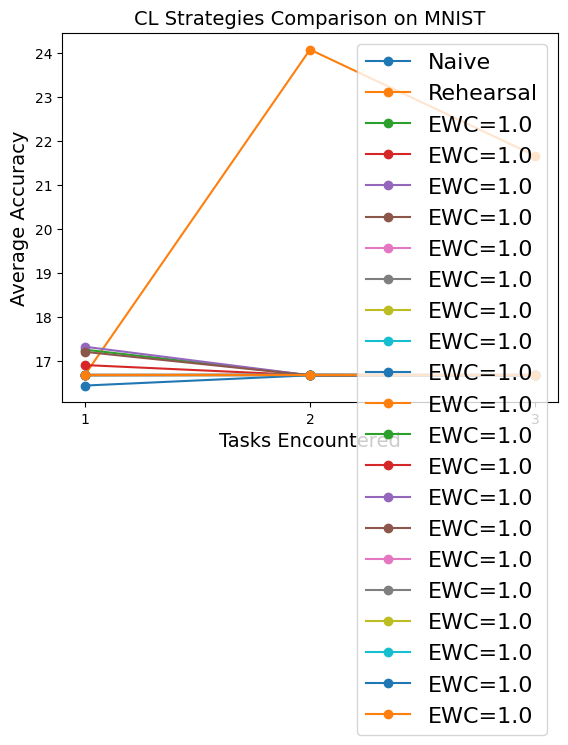

In [116]:
plt.plot([1, 2, 3], naive_accs, '-o', label="Naive")
plt.plot([1, 2, 3], rehe_accs, '-o', label="Rehearsal")
for key, value in ewc_accs_ewc_lambda.items():
    plt.plot([1, 2, 3], value, '-o', label=f"EWC={ewc_lambdas[i]}")
plt.xlabel('Tasks Encountered', fontsize=14)
plt.ylabel('Average Accuracy', fontsize=14)
plt.title('CL Strategies Comparison on MNIST', fontsize=14);
plt.xticks([1, 2, 3])
plt.legend(prop={'size': 16});

**Questions to explore:**

*   What's the difference in terms of memory utilization among the three methods?
*   Can you plot a similar graph highlighting the memory increase over time?

Some tips here: https://stackoverflow.com/questions/449560/how-do-i-determine-the-size-of-an-object-in-python/30316760

**Copyright (c) 2018. Continual AI. All rights reserved. **

See the accompanying LICENSE file in the GitHub repository for terms.

*Date: 29-09-2018                                                             
Author: Vincenzo Lomonaco                                                    
E-mail: contact@continualai.org                                           
Website: continualai.org*                                               